In [1]:
!pip install pandas-plink limix-lmm


[notice] A new release of pip is available: 25.3 -> 26.0.1
[notice] To update, run: pip install --upgrade pip


In [2]:
import numpy as np
from pandas_plink import read_plink
from limix_lmm import LMM
import matplotlib.pyplot as plt
import pandas as pd
import scipy.stats as st
import statsmodels.api as sm
from sklearn.preprocessing import StandardScaler
from tqdm import tqdm
from statsmodels.stats.multitest import multipletests
import seaborn as sns

In [3]:
import scipy
import scipy.stats as st

if not hasattr(scipy, 'dot'):
    scipy.dot = np.dot
if not hasattr(scipy, 'einsum'):
    scipy.einsum = np.einsum
if not hasattr(scipy, 'log'):
    scipy.log = np.log
if not hasattr(scipy, 'sign'):
    scipy.sign = np.sign
if not hasattr(scipy, 'sqrt'):
    scipy.sqrt = np.sqrt

### Preprocessing pipeline

BFILE=/Users/oykusuoglu/gobi/gobi_gwas/oyku/data/ALL.chr22_GRCh38.genotypes.20170504

OUTDIR=/Users/oykusuoglu/gobi/gobi_gwas/oyku/data/qc

mkdir -p "$OUTDIR"


plink --bfile "$BFILE" --freq --missing --out "$OUTDIR"/initial_qc


Preprocessing 

We only kept SNP like variants (single base substitutions), dropped variants with missing rate > 0.02 and minor allele frequency < 0.01 to keep only commons, and also variants that have extreme deviations that are caused by noise rather than signal

(filtered data set written as a new bed/bim/fam)


plink --bfile "$BFILE" \
  --snps-only \
  --geno 0.02 \
  --maf 0.01 \
  --hwe 1e-6 \
  --make-bed \
  --out "$OUTDIR"/chr22_step1_common


check if there are duplicate variant ids

plink --bfile "$OUTDIR"/chr22_step1_common \
  --list-duplicate-vars ids-only suppress-first \
  --out "$OUTDIR"/dupcheck

wc -l "$OUTDIR"/dupcheck.dupvar

there were no duplicates (0)

plink --bfile "$OUTDIR"/chr22_step1_common \
  --exclude "$OUTDIR"/dupcheck.dupvar \
  --make-bed \
  --out "$OUTDIR"/chr22_step2_nodup

sample level missingness, none was filtered (both chr22_step2_nodup.fam and chr22_step3_sampleqc.fam are same size 2504)

plink --bfile "$OUTDIR"/chr22_step2_nodup \
  --mind 0.02 \
  --make-bed \
  --out "$OUTDIR"/chr22_step3_sampleqc




INITIAL:

Number of variants: 109827 

Number of samples: 2504

AFTER QC:

Number of variants: 59743

Number of samples: 2504


In [4]:
bfile = 'data/qc/chr22_step3_sampleqc'
bim, fam, G = read_plink(bfile)

Mapping files: 100%|██████████| 3/3 [00:00<00:00, 44.56it/s]
/opt/anaconda3/envs/gobi_venv/lib/python3.10/site-packages/pandera/_pandas_deprecated.py:146: FutureWarning: Importing pandas-specific classes and functions from the
top-level pandera module will be **removed in a future version of pandera**.
If you're using pandera to validate pandas objects, we highly recommend updating
your import:

```
# old import
import pandera as pa

# new import
import pandera.pandas as pa
```

If you're using pandera to validate objects from other compatible libraries
like pyspark or polars, see the supported libraries section of the documentation
for more information on how to import pandera:

https://pandera.readthedocs.io/en/stable/supported_libraries.html

To disable this warning, set the environment variable:

```
export DISABLE_PANDERA_IMPORT_WARNING=True
```

  warnings.warn(_future_warning, FutureWarning)


In [5]:
n_snps = bim.shape[0]
n_samples = fam.shape[0]
n_snps, n_samples

(59743, 2504)

In [6]:
def extract_region(bim, G, chrom, start, end):
    I1 = bim['chrom']==str(chrom)
    I2 = bim['pos'] > start
    I3 = bim['pos'] < end
    Ikeep = I1 * I2 * I3
    bim = bim.loc[Ikeep].copy()
    G = G[bim['i'].values]
    bim['i'] = np.arange(len(bim))
    return bim, G

def subset_individuals(fam, G, keep_idxs):
    fam = fam.iloc[keep_idxs]
    G = G[:, keep_idxs]
    return fam, G

In [7]:
N = 1000
np.random.seed(0)
idxs = np.sort(np.random.permutation(fam.shape[0])[:N])
fams, Gs = subset_individuals(fam, G, idxs)

In [8]:
chrom = 22
start = 30797531
size = 100000
bimr, Gr = extract_region(bim, Gs, chrom, start, start + size)

In [9]:
X_real_extracted = Gr.compute().T

In [10]:
X_real = G.compute().T

Standardize the genotype matrix, so that all SNPs are on the same scale, 3 variants were dropped, which had a standard deviation equals to 0 among all individuals. (bim annotation table must be also updated)

In [11]:
#if we extract a specific region

mu = X_real_extracted.mean(axis=0)
sd = X_real_extracted.std(axis=0, ddof=0)
keep = sd > 1e-12
standardized_X_extracted = (X_real_extracted[:, keep] - mu[keep]) / sd[keep]

In [12]:
#whole chromosome 22

mu_full = X_real.mean(axis=0)
sd_full = X_real.std(axis=0, ddof=0)
keep_full = sd_full > 1e-12
keep_idx  = np.where(keep_full)[0] 
standardized_X = (X_real[:, keep_full] - mu_full[keep_full]) / sd_full[keep_full]

In [13]:
# bim data for variants that werent dropped after the standardization
bim_kept = bim.iloc[keep_idx].copy().reset_index(drop=True)

bim_kept["orig_bim_idx"] = keep_idx

In [14]:
X_real.shape

(2504, 59743)

### Phase 1: Phenotype Simulation

First, we need to set the parameters (heritability and number of casual SNPs):

In [15]:
rng = np.random.default_rng(42)
M = 10 #vary between 10:100
h2 = 0 #vary between 0.1:0.6

idx_caus = rng.choice(X_real.shape[1], size=M, replace=False)
var_expl = np.repeat(h2/M, M)

Code from GWAS exercise to simulate phenotypes (maybe delete the standardization part from here since its been done beforehand):

In [16]:
def simulate_pheno_random(X, idx_caus, var_expl, direction=None):
    # Ensure that the number of causal variant indices matches the number of variances explained.
    assert len(idx_caus) == len(var_expl)

    # If no direction is provided, randomly assign a positive or negative direction for each causal variant.
    if direction is None:
        direction = 2. * (rng.random(len(idx_caus)) > 0.5) - 1.
    # Ensure that the number of directions matches the number of causal variant indices.
    assert len(idx_caus) == len(direction)

    # Compute the remaining variance after accounting for the variance explained by the causal variants.
    ve = 1 - var_expl.sum()
    # Ensure that the total variance explained by causal variants is less than 1.
    assert ve > 0, 'sum(var_expl) should be < 1'

    # Compute the effect sizes for the causal variants based on the variance they explain and their direction.
    beta = np.sqrt(var_expl) * direction

    # Extract the columns of X corresponding to the causal variants and standardize them.
    Xc = X[:, idx_caus]
    Xc = (Xc - Xc.mean(0)) / Xc.std(0)

    # Compute the genetic component of the phenotype.
    yg = Xc.dot(beta)[:, None]
    # Compute the noise component of the phenotype.
    yn = np.sqrt(ve) * rng.standard_normal(size=(X.shape[0], 1))

    # Sum the genetic and noise components to get the simulated phenotype.
    y = yg + yn

    # Initialize the real effect sizes for all variants in X as zeros.
    beta_real = np.zeros(X.shape[1])
    # Update the real effect sizes for the causal variants.
    beta_real[idx_caus] = beta

    # Standardize the phenotypic values to have mean 0 and standard deviation 1.
    ystd = y.std()
    y = (y - y.mean()) / ystd
    # Adjust the real effect sizes accordingly after standardizing y.
    beta_real = beta_real / ystd

    return y, beta_real

In [17]:
def simulate_pheno(X, idx_caus, var_expl, rng, direction=None):
    # Ensure that the number of causal variant indices matches the number of variances explained.
    assert len(idx_caus) == len(var_expl)

    # If no direction is provided, randomly assign a positive or negative direction for each causal variant.
    if direction is None:
        direction = 2. * (rng.random(len(idx_caus)) > 0.5) - 1.
    # Ensure that the number of directions matches the number of causal variant indices.
    assert len(idx_caus) == len(direction)

    # Compute the remaining variance after accounting for the variance explained by the causal variants.
    ve = 1 - var_expl.sum()
    # Ensure that the total variance explained by causal variants is less than 1.
    assert ve > 0, 'sum(var_expl) should be < 1'

    # Compute the effect sizes for the causal variants based on the variance they explain and their direction.
    beta = np.sqrt(var_expl) * direction

    # Extract the columns of X corresponding to the causal variants and standardize them.
    Xc = X[:, idx_caus]
    Xc = (Xc - Xc.mean(0)) / Xc.std(0)

    # Compute the genetic component of the phenotype.
    yg = Xc.dot(beta)[:, None]
    # Compute the noise component of the phenotype.
    yn = np.sqrt(ve) * rng.standard_normal((X.shape[0], 1))

    # Sum the genetic and noise components to get the simulated phenotype.
    y = yg + yn

    # Initialize the real effect sizes for all variants in X as zeros.
    beta_real = np.zeros(X.shape[1])
    # Update the real effect sizes for the causal variants.
    beta_real[idx_caus] = beta

    # Standardize the phenotypic values to have mean 0 and standard deviation 1.
    ystd = y.std()
    y = (y - y.mean()) / ystd
    # Adjust the real effect sizes accordingly after standardizing y.
    beta_real = beta_real / ystd

    return y, beta_real

In [18]:
def qq_plot(p_values, title):
    """
    Create a QQ plot given a list of p-values.

    Parameters:
    - p_values: list of p-values
    - title: title for the plot
    """

    # Sort p-values
    observed = -np.log10(np.sort(p_values))
    expected = -np.log10(np.arange(1, len(p_values) + 1) / (len(p_values) + 2))

    # Create the QQ plot
    plt.scatter(expected, observed, marker='.')
    plt.plot([0, max(expected)], [0, max(expected)], color='red', linestyle='--')
    plt.xlabel('Expected -log10(P-value)')
    plt.ylabel('Observed -log10(P-value)')
    plt.title(title)

Apply the code:

In [19]:
y, beta_real = simulate_pheno(X_real, idx_caus, var_expl, rng)

In [20]:
y.shape

(2504, 1)

##### LD Pruning for PCA & PCA

plink --bfile data/final/chr22_step3_sampleqc \
  --indep-pairwise 200 50 0.2 \
  --out chr22_prune

plink --bfile data/final/chr22_step3_sampleqc \
  --extract chr22_prune.prune.in \
  --pca 10 \
  --out chr22_pca

##### 1) build phenotype table with IDs

In [21]:
fam.columns

Index(['fid', 'iid', 'father', 'mother', 'gender', 'trait', 'i'], dtype='object')

In [22]:
pheno = fam[["fid","iid"]].copy()
pheno.columns = ["FID","IID"]
pheno["y"] = y.reshape(-1)

##### 2) load PCs and merge

In [23]:
pcs = pd.read_csv("data/pca/chr22_pca.eigenvec", sep=r"\s+", header=None, engine="python")
pcs.columns = ["FID","IID"] + [f"PC{i}" for i in range(1, pcs.shape[1]-1)]

df = pheno.merge(pcs, on=["FID","IID"], how="inner", validate="one_to_one")

##### 3) build F (intercept + PCs) for LMM

In [24]:
k = 10
F = np.column_stack([np.ones((df.shape[0], 1)),
                     df[[f"PC{i}" for i in range(1, k+1)]].to_numpy()])

In [25]:
df

,FID,IID,y,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10
0,HG00096,HG00096,-0.143277,-0.011046,-0.027328,0.011683,-0.018842,0.004517,0.008834,-0.016326,-0.005232,0.010859,-0.021377
1,HG00097,HG00097,-0.636068,-0.010830,-0.026543,0.014283,-0.010589,0.002204,-0.008320,-0.000895,-0.005648,-0.008883,0.007142
2,HG00099,HG00099,1.254832,-0.010240,-0.028411,0.006507,-0.012634,-0.009396,0.001666,-0.022650,-0.003093,0.017156,-0.013872
3,HG00100,HG00100,-0.113145,-0.009784,-0.028327,0.016192,-0.022707,-0.002332,0.012731,-0.005662,-0.001656,0.008886,-0.016668
4,HG00101,HG00101,-0.385135,-0.010198,-0.025355,0.014540,-0.016269,-0.004434,0.024239,-0.017158,-0.019334,0.008474,0.005293
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2499,NA21137,NA21137,-1.659806,-0.010405,-0.007080,-0.036371,0.015395,-0.014689,-0.003549,0.003435,0.002731,0.001510,0.008935
2500,NA21141,NA21141,-0.173459,-0.011852,-0.005287,-0.052369,0.013678,-0.005221,0.006215,0.002406,0.000747,-0.019995,0.012510
2501,NA21142,NA21142,1.810887,-0.009961,-0.004021,-0.036816,0.009858,0.014469,0.003172,-0.008175,0.004308,0.026670,0.002699
2502,NA21143,NA21143,-0.172021,-0.007582,-0.003443,-0.046927,0.008133,-0.008578,0.003928,-0.014795,-0.023491,0.010243,0.035407


### Phase 2: GWAS / Feature Selection

Now we have:

- our genotype matrix **`standardized_X`** which was first standardized (before that it was **`X_real`**) and then used to simulate the phenotype matrix
- our simulated phenotype matrix **`y`** 
- our covariates (PCs) **`F`**

#### 1. Training/Validation Set Split

In [26]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test, F_train, F_test = train_test_split(
    X_real, y, F,
    test_size=0.3,
    random_state=42,
    shuffle=True
)

In [27]:
X_train.shape, y_train.shape, F_train.shape

((1752, 59743), (1752, 1), (1752, 11))

#### 2. GWAS

GWAS is only peformed on the training set (training genotype matrix **`X_train`** and phenotype matrix **`y_train`**)

In [28]:
F_t = np.ones((len(y_train), 1))
lmm = LMM(y_train, F_train)
lmm.process(X_train)
pv = lmm.getPv()
beta = lmm.getBetaSNP()
beta_ste = lmm.getBetaSNPste()

In [29]:
pv.shape

(59743,)

In [30]:
np.isnan(pv).any(), np.isnan(pv).sum(), np.where(np.isnan(pv)) 

(True, 3, (array([  215,  7331, 33021]),))

In [31]:
#the i-th p-value matches bim_kept.iloc[i]
"""
assert keep_full.shape[0] == bim.shape[0]         
assert X_train.shape[1] == keep_full.sum()
bim_kept = bim.loc[keep_full].copy().reset_index(drop=True)
assert bim_kept.shape[0] == len(pv)

"""

'\nassert keep_full.shape[0] == bim.shape[0]         \nassert X_train.shape[1] == keep_full.sum()\nbim_kept = bim.loc[keep_full].copy().reset_index(drop=True)\nassert bim_kept.shape[0] == len(pv)\n\n'

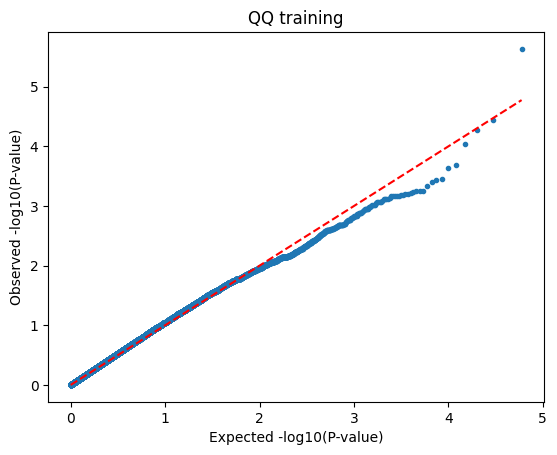

In [32]:
qq_plot(pv, 'QQ training')
plt.show()

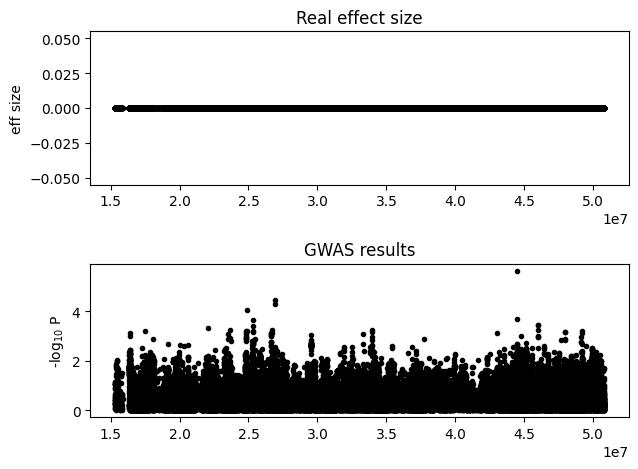

In [33]:
x = bim['pos'].values
plt.subplot(211)
plt.title('Real effect size')
plt.plot(x, beta_real, '.k')
plt.ylabel('eff size')
plt.subplot(212)
plt.title('GWAS results')
plt.plot(x, -np.log10(pv), '.k')
plt.ylabel('-log$_{10}$ P')
plt.tight_layout()
plt.show()

#### 3. Clumping using PLINK 

First create a file with SNP ids and their corresponding p-values

In [34]:
gwas_for_clump = pd.DataFrame({
    "SNP": bim["snp"].astype(str),   
    "P": np.asarray(pv, dtype=float)
})
gwas_for_clump.to_csv("gwas_for_clump.txt", sep="\t", index=False)

clump-p1: p-val threshold for index SNPs
clump-p2: secondary p val threshold for SNPs
clump-r2: LD threshold for joining a SNP to an index SNPs clump 
clump-kb: window radius around the index SNP 

can try playing around with the parameter

plink \
  --bfile data/final/chr22_step3_sampleqc \
  --clump gwas_for_clump.txt \
  --clump-snp-field SNP \
  --clump-field P \
  --clump-p1 1e-4 \
  --clump-p2 1e-2 \
  --clump-r2 0.1 \
  --clump-kb 250 \
  --out chr22_clumped


plink \
  --bfile data/final/chr22_step3_sampleqc \
  --clump gwas_for_clump.txt \
  --clump-snp-field SNP \
  --clump-field P \
  --clump-p1 1 \
  --clump-r2 0.1 \
  --clump-kb 500 \
  --out chr22_clumped


try these: --clump-p1 1 --clump-r2 0.1 --clump-kb 500 

In [35]:
# snp IDs used in GWAS (aligned with pv)
snps_gwas = set(bim["snp"].astype(str))   

# SNP IDs in PLINK reference
bim_ref = pd.read_csv("data/qc/chr22_step3_sampleqc.bim", sep=r"\s+", header=None)
bim_ref.columns = ["chrom","snp","cm","pos","a1","a2"]
snps_ref = set(bim_ref["snp"].astype(str))

missing = snps_gwas - snps_ref
print("missing in plink ref:", len(missing))

missing in plink ref: 0


In [36]:
clumped = pd.read_csv("chr22_clumped.clumped", sep=r"\s+", engine="python")
lead_snps = clumped["SNP"].astype(str).tolist()

In [37]:
len(lead_snps), lead_snps[:5]

(4236, ['rs111383589', 'rs4824002', 'rs76554645', 'rs1535186', 'rs5761294'])

In [38]:
snp_to_col = pd.Series(index=bim["snp"].astype(str), data=range(bim.shape[0]))
cols = snp_to_col.reindex(lead_snps).dropna().astype(int).to_numpy()
cols


array([25499, 55610, 52615, ..., 59605, 47476, 40971])

In [39]:
X_clump_train = X_train[:, cols] 
X_clump_test = X_test[:, cols]   

### Phase 3: Model Development

Train a regression model to predict the phenotype based on the selected SNPs and test it on the
validation set

In [40]:
from sklearn import linear_model
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score, mean_squared_error


**`X_clump_train`**: training genotype matrix only including clumped SNPs

**`X_clump_test`**: test genotype matrix only including clumped SNPs

**`y_train`**: training phenotypes

**`y_test`**: test phenotypes


In [41]:
y_train = y_train.reshape(-1)
y_test = y_test.reshape(-1)

In [42]:
regr = linear_model.LinearRegression()
regr.fit(X_clump_train, y_train)

y_pred = regr.predict(X_clump_test)

R2: close to 1 ~ good performance

MSE: close to 0 ~ good performance 

spearman r: 
- close to -1 ~ monotonic negative correlation
- close to 1 ~ monotonic positive correlation


In [43]:
from scipy import stats
spearman = stats.spearmanr(y_test, y_pred)
print("R2", r2_score(y_test, y_pred))
print("MSE:", mean_squared_error(y_test, y_pred))
print("spearman r: ", spearman.statistic)

R2 -0.8875515086235497
MSE: 1.9302800675789624
spearman r:  -0.00033424395175058044


In [44]:
def plot_prediction(y_pred, input, model):
    plt.scatter(y_test, y_pred)

    xx = np.linspace(y_pred.min(), y_pred.max(), 200)

    plt.plot(xx, xx, linewidth=2, linestyle="--", label="ideal: y=x", color="orange")
    plt.title(f"{model} with {input}")
    plt.xlabel("Phenotype true")
    plt.ylabel("Phenotype predicted")
    plt.show()

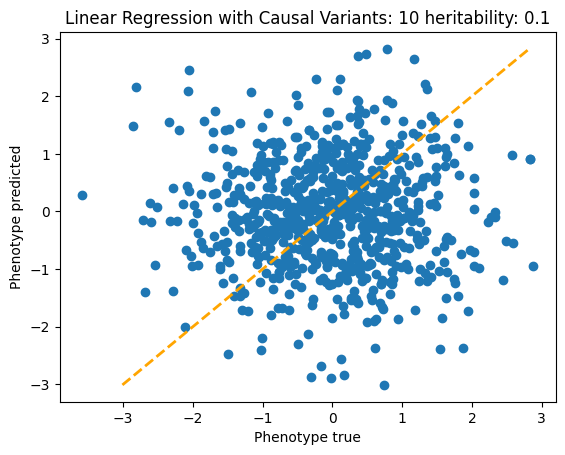

In [45]:
plot_prediction(y_pred, input="Causal Variants: 10 heritability: 0.1", model="Linear Regression")